# Indicateur tourisme Côte d'Azur

1ère méthode :  
Essayer de prédire les données officielles à partir des données officielles passées uniquement.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Réduction des données officielles à la Côte d'Azur

In [2]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])

In [3]:
#Données Côte d'Azur
df_Official_Data_Sud = df_France_Official_Data2[(df_France_Official_Data2['department']=='Bouches-du-Rhône') 
                                               | (df_France_Official_Data2['department']=='Alpes-Maritimes')
                                               | (df_France_Official_Data2['department']=='Var')]
df_Official_Data_Sud.head(5)

,date,department,value_in_thousands
3,2011-01-01,Alpes-Maritimes,170.80
12,2011-01-01,Bouches-du-Rhône,153.08
89,2011-01-01,Var,62.69
99,2011-02-01,Alpes-Maritimes,205.43
108,2011-02-01,Bouches-du-Rhône,156.19


In [110]:
#On regroupe par mois
df_Official_Data_Sud2 = df_Official_Data_Sud.groupby('date').sum() 
df_Official_Data_Sud2.head(5)

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64
2011-04-01,738.92
2011-05-01,828.78


## Représentation de la série

<AxesSubplot:xlabel='date'>

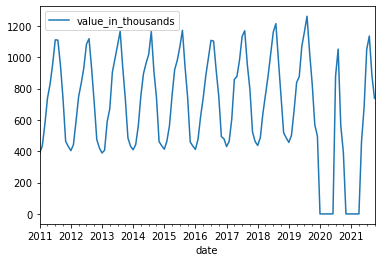

In [5]:
df_Official_Data_Sud2.plot()

/!\ Il y a bcp de valeurs à 0 en 2020 et 2021 avec le covid.

In [6]:
#On se restreint à une période stable ie avant le confinement. On garde les obs avant 2020.
df_Official_Data_Sud2_index = df_Official_Data_Sud2.reset_index()
df_Official_Data_Sud3 = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']<"2020-01-01"]
df_Official_Data_Sud3.set_index('date', inplace=True)
df_Official_Data_Sud3

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64
2011-04-01,738.92
2011-05-01,828.78
...,...
2019-08-01,1261.63
2019-09-01,1028.80
2019-10-01,828.72


## Stationnarité

La stationnarité signifie que les statistiques de la série temporelle ne dépendent pas du temps. En particulier cela veut dire que il n’y a pas de tendance générale et que les variations apparaissent comme d’amplitude constante. 

  
  
Il y a deux façons principales de déterminer si une série temporelle donnée est stationnaire:

Statistiques roulantes : Tracer la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps (à l’œil nu, regardez si les lignes sont droites et parallèles à l’axe des x)  
Test de Dickey-Fuller augmenté (ADF) : La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

### Méthode 1 : moyenne mobile sur 6 mois et écart-type mobile sur 6 mois

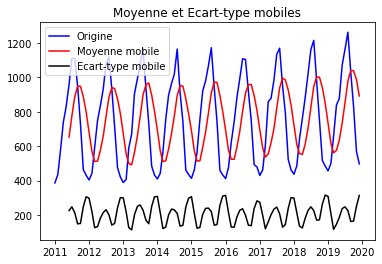

In [7]:
#Méthode 1 : moyenne mobile sur 6 mois et écart-type mobile sur 6 mois

rolling_mean = df_Official_Data_Sud3.rolling(window = 6).mean()
rolling_std = df_Official_Data_Sud3.rolling(window = 6).std()
plt.plot(df_Official_Data_Sud3, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

### Méthode 2 : Test ADF

In [8]:
#Methode 2 : Test ADF

result = adfuller(df_Official_Data_Sud3['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 1.730396934364561
p-value : 0.9982005019252823
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


La statistique ADF est loin des valeurs critiques et la p-value est supérieure à 0,05. Donc la série temporelle n’est pas stationnaire.

### On stationnarise la série

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary. So what is differencing? If Y_t is the value at time ‘t’, then the first difference of Y = Yt – Yt-1. 

In [9]:
#Différenciation de premier ordre
df_Official_Data_Sud3_diff = df_Official_Data_Sud3 - df_Official_Data_Sud3.shift()
df_Official_Data_Sud3_diff

,value_in_thousands
date,
2011-01-01,NaN
2011-02-01,48.16
2011-03-01,137.91
2011-04-01,166.28
2011-05-01,89.86
...,...
2019-08-01,99.60
2019-09-01,-232.83
2019-10-01,-200.08


Text(0.5, 1.0, 'Série différenciée')

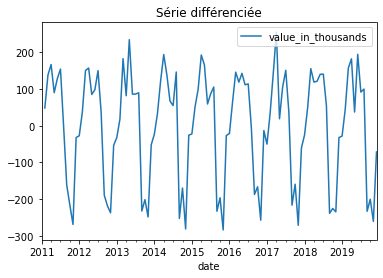

In [10]:
df_Official_Data_Sud3_diff.plot()
plt.title("Série différenciée")

In [11]:
#On supprime le NA 
df_Official_Data_Sud3_diff.dropna(inplace=True)

In [12]:
#Test ADF

result = adfuller(df_Official_Data_Sud3_diff['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -20.923325269098676
p-value : 0.0
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


La p-value est <0,05, la série est stationnaire.

## Décomposition

La décomposition d’une série temporelle consiste à séparer sa série initiale en plusieurs sous-séries plus simples, chacune représentant un aspect essentiel de la série initiale. Une décomposition typique est la décomposition en 3 séries: tendance, périodique et reste. On retrouve la série originale si on somme les 3 séries composantes.

Dans le graphe ci-dessous on sépare les composantes de tendance, périodique, et le reste avant de les afficher. Notez que l’on applique la décomposition à la série dont la variance a été stabilisée, afin d’avoir une composante périodique qui reste stable dans le temps. Pour l’affichage, on inverse la transformation logarithmique (avec la fonction ‘exp’) pour avoir les données dans l’unité originale.

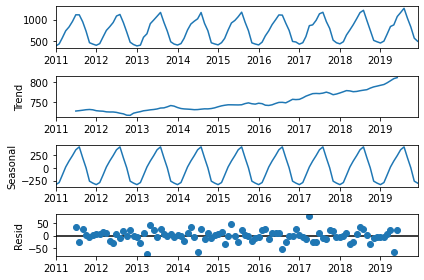

In [13]:
decompose = seasonal_decompose(df_Official_Data_Sud3, period=12) #je ne sais pas quelle valeur mettre à period
decompose.plot()
plt.show()

## Fonction d'auto-corrélation (ACF) et d'auto-corrélation partielle (PACF)

Trois entiers (p, d, q) sont généralement utilisés pour paramétrer les modèles ARIMA :  
p : nombre de termes autorégressifs (ordre AR)  
d : nombre de différences non saisonnières (ordre de différenciation)  
q : nombre de termes moyens mobiles (ordre MA)  

Nous pouvons utiliser l’ACF pour déterminer le nombre optimal de termes MA. Nous pouvons utiliser le PACF pour déterminer le nombre optimal de termes à utiliser dans le modèle AR. 

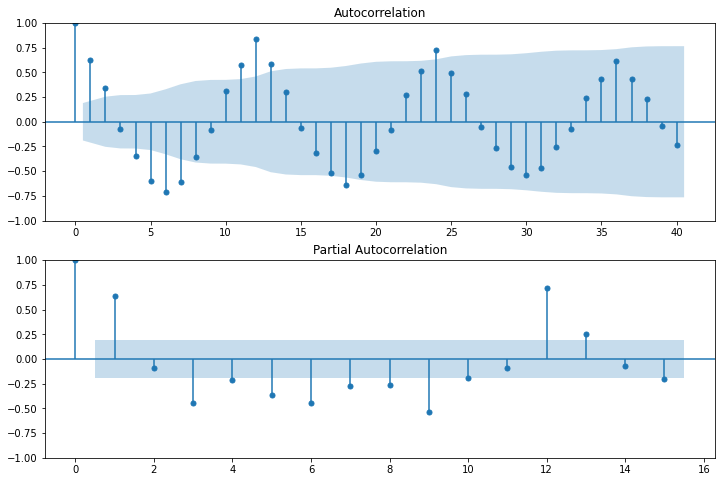

In [14]:
#sur la série différenciée

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Official_Data_Sud3_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Official_Data_Sud3_diff, lags=15, ax=ax2); 

ACF : utiliser les 3 mois précédents dans l'équation de la moyenne mobile.  
PACF : utiliser les 2 mois précédents dans l'équation d'auto-régression.

## Modèle ARIMA

### Modèle ARIMA

On crée et ajuste un modèle ARIMA avec un AR d’ordre 2, une différence d’ordre 1 et un MA d’ordre 3.

In [15]:
model = ARIMA(df_Official_Data_Sud3, order=(2,1,3)) #(p,d,q)
results_ARIMA = model.fit()
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     value_in_thousands   No. Observations:                  108
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -589.722
Date:                Mon, 11 Apr 2022   AIC                           1191.444
Time:                        16:02:30   BIC                           1207.481
Sample:                    01-01-2011   HQIC                          1197.945
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7293      0.004    462.385      0.000       1.722       1.737
ar.L2         -0.9974      0.003   -313.960      0.000      -1.004      -0.991
ma.L1         -2.7144      0.175    -15.516      0.000      -3.057      -2.372
ma.L2          2.6119      0.344      7.595      0.000       1.938       3.286
ma.L3         -0.8796      0.173     -5.096      0.000      -1.218      -0.541
sigma2      3334.9875    803.345      4.151      0.000    1760.460    4909.515
===================================================================================
Ljung-Box (L1) (Q):                   4.67   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.03   Prob(JB):                         0.84
Heteroskedasticity (H):               1.30   Skew:                             0.11
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Tous les coeff sont significatifs car les p-values sont inférieures à 5%.

### Résidus

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7293      0.004    462.385      0.000       1.722       1.737
ar.L2         -0.9974      0.003   -313.960      0.000      -1.004      -0.991
ma.L1         -2.7144      0.175    -15.516      0.000      -3.057      -2.372
ma.L2          2.6119      0.344      7.595      0.000       1.938       3.286
ma.L3         -0.8796      0.173     -5.096      0.000      -1.218      -0.541
sigma2      3334.9875    803.345      4.151      0.000    1760.460    4909.515


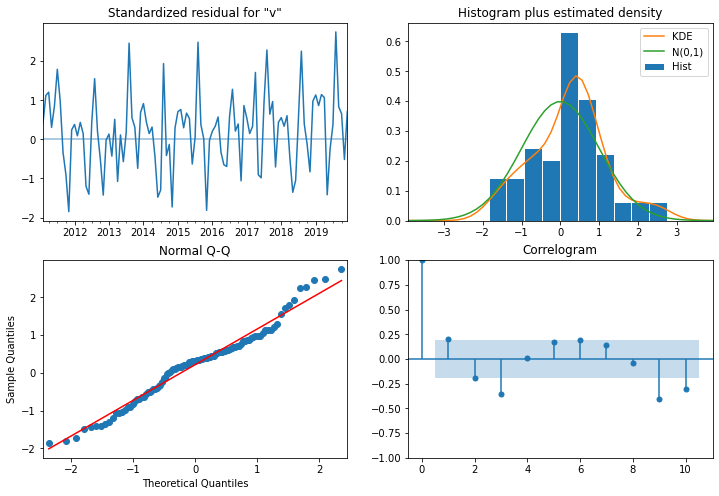

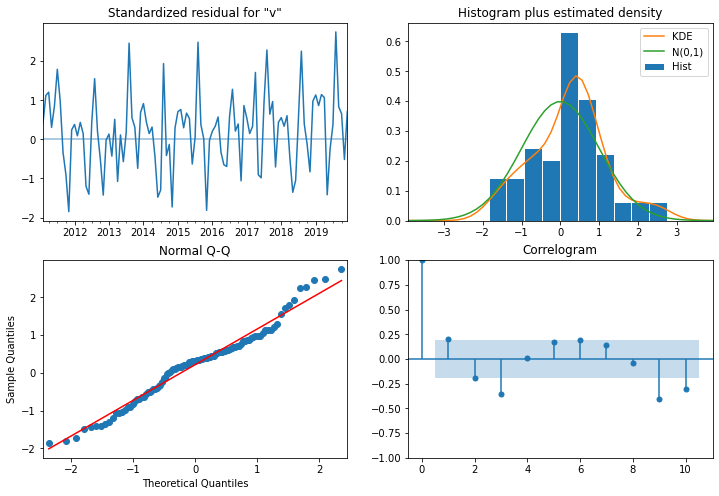

In [16]:
print(results_ARIMA.summary().tables[1])
#Check residuals
results_ARIMA.plot_diagnostics(figsize=(12, 8))

We can also do line and density plot of residuals.

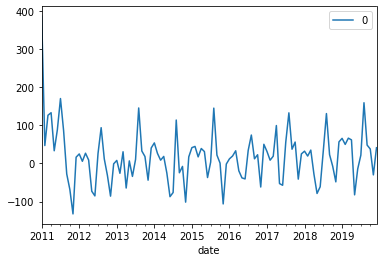

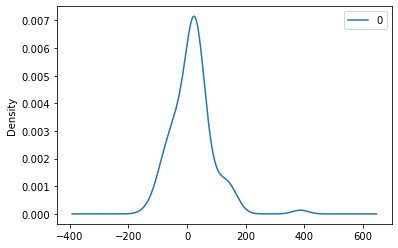

                0
count  108.000000
mean    18.322006
std     69.885778
min   -132.422684
25%    -26.205958
50%     19.311883
75%     42.366453
max    386.570000


In [17]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

As we see above, mean is not exactly zero that means there is some bias in the data.

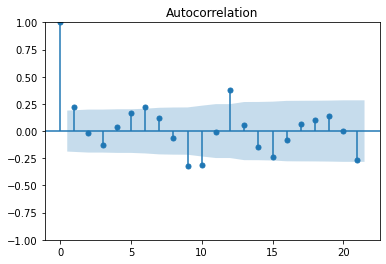

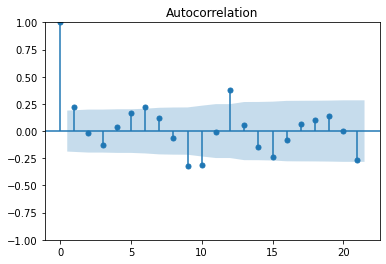

In [18]:
plot_acf(residuals)

Les résidus ont quelques autocorrélations en dehors de l'intervalle de confiance.

### Test portmanteau

In [19]:
sm.stats.acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,5.489680,0.019129
2,5.511236,0.063570
3,7.276753,0.063581
4,7.400668,0.116170
5,10.642471,0.058948
6,16.591369,0.010908
7,18.412859,0.010240
8,18.903646,0.015384
9,31.110548,0.000283
10,42.885859,0.000005


Les p-value sont faibles (toutes <5% sauf au lag 4) : on rejette le modèle ARIMA(2,1,3)

### Prédiction

Étant donné que nous disposons de données pour chaque mois remontant à 10 ans et que nous voulons prévoir le nombre de touristes sur la Côte d'Azur pour les 10 prochaines années, nous utilisons (12 x 10) + (12 x 10) = 240.

In [20]:
df_Official_Data_Sud_forecast = df_Official_Data_Sud3.copy()

<AxesSubplot:xlabel='date'>

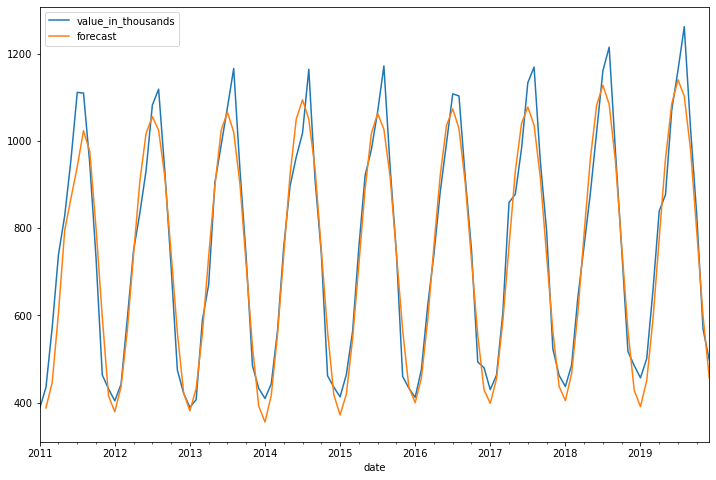

In [21]:
df_Official_Data_Sud_forecast['forecast'] = results_ARIMA.predict(start=1, end=108)
df_Official_Data_Sud_forecast[['value_in_thousands','forecast']].plot(figsize=(12,8))

La prédiction est bien.

In [22]:
from pandas.tseries.offsets import DateOffset
future_dates=[df_Official_Data_Sud_forecast.index[-1]+ DateOffset(months=x)for x in range(0,60)] #on rajoute 5 années

In [23]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_Official_Data_Sud_forecast.columns)
future_datest_df.head(5) #on a les dates de 2020 à 2024, avec aucune observation comme c'est ce qu'on prédit

,value_in_thousands,forecast
2020-01-01,NaN,NaN
2020-02-01,NaN,NaN
2020-03-01,NaN,NaN
2020-04-01,NaN,NaN
2020-05-01,NaN,NaN


In [24]:
future_df=pd.concat([df_Official_Data_Sud_forecast,future_datest_df]) #on concatène les dates avec des obs et les dates qu'on prédit

<AxesSubplot:>

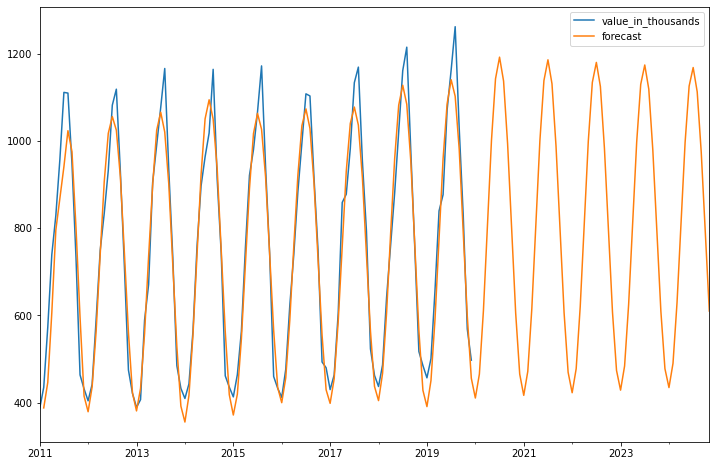

In [25]:
future_df['forecast'] = results_ARIMA.predict(start = 1, end = 167)  
future_df[['value_in_thousands', 'forecast']].plot(figsize=(12, 8)) 

#### RMSE

In [26]:
df_Official_Data_Sud_forecast.dropna(inplace=True) #on supprime janvier 2011 car y a NA pour forecast

In [27]:
rmse = mean_squared_error(df_Official_Data_Sud_forecast['value_in_thousands'], df_Official_Data_Sud_forecast['forecast'], squared=False)
rmse

61.85671870957225

#### Vérif choix du modèle ARIMA avec les AIC et BIC

In [28]:
def choix_modele_arima(pmax, dmax, qmax):

    p = q = range(0,pmax)
    d = range(0,dmax)
    pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q

    parametres = {} # stores aic and order pairs
    parametres_bic = {}
    aics = [] # stores aics
    bics = []

    # Grid Search continued
    for param in pdq:
        try:
            model = ARIMA(df_Official_Data_Sud3, order=param) # create all possible models
            model = model.fit()
            parametres.update({model.aic : param}) # store combinations
            parametres_bic.update({model.bic : param}) # store combinations
            aics.append(model.aic)
            bics.append(model.bic)

        except:
            continue

    best_aic = min(aics)
    best_bic = min(bics)

    print(best_aic)
    print(parametres[best_aic])

    print(best_bic)
    print(parametres_bic[best_bic])

In [29]:
choix_modele_arima(4,3,4)

1191.4441115489133
(2, 1, 3)
1207.4810845556847
(2, 1, 3)


Les résultats suggèrent que le meilleur modèle c'est un ARIMA(2,1,3). C'est bien celui qu'on avait choisi !

## SARIMA

The models notation is SARIMA(p, d, q).(P,D,Q)m

### Choix du modèle avec les AIC

The AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better.

In [30]:
p = range(0, 6)
q = range(0, 4)
d = range(0,3)
pdq = list(itertools.product(p, d, q))

p2 = d2 = q2 = range(0, 2)
seasonal_pdq = list(itertools.product(p2,d2,q2))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]

In [31]:
parametres = {}
parametres_bic = {}
aics = []
bics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_Official_Data_Sud3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            parametres.update({results.aic : [param, param_seasonal]})
            parametres_bic.update({results.bic : [param, param_seasonal]})
            aics.append(results.aic)
            bics.append(results.bic)

            
        except: 
            continue

best_aic = min(aics)
print(best_aic)
print(parametres[best_aic])

best_bic = min(bics)
print(best_bic)
print(parametres_bic[best_bic])

754.1219767326962
[(0, 2, 3), (0, 1, 1, 12)]
765.9055208661442
[(0, 2, 3), (0, 1, 1, 12)]


Les résultats avec l'AIC et le BIC suggèrent que le meilleur modèle c'est SARIMAX(0, 2, 3)x(0, 1, 1, 12).

### Modélisation

In [32]:
mod = sm.tsa.statespace.SARIMAX(df_Official_Data_Sud3,
                                order=parametres[best_aic][0],
                                seasonal_order=parametres[best_aic][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   value_in_thousands   No. Observations:                  108
Model:             SARIMAX(0, 2, 3)x(0, 1, [1], 12)   Log Likelihood                -372.061
Date:                              Mon, 11 Apr 2022   AIC                            754.122
Time:                                      16:12:43   BIC                            765.906
Sample:                                  01-01-2011   HQIC                           758.839
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0571     36.792     -0.056      0.955     -74.169      70.054
ma.L2          1.13

Aucune p-value n'est significative.

### Résidus

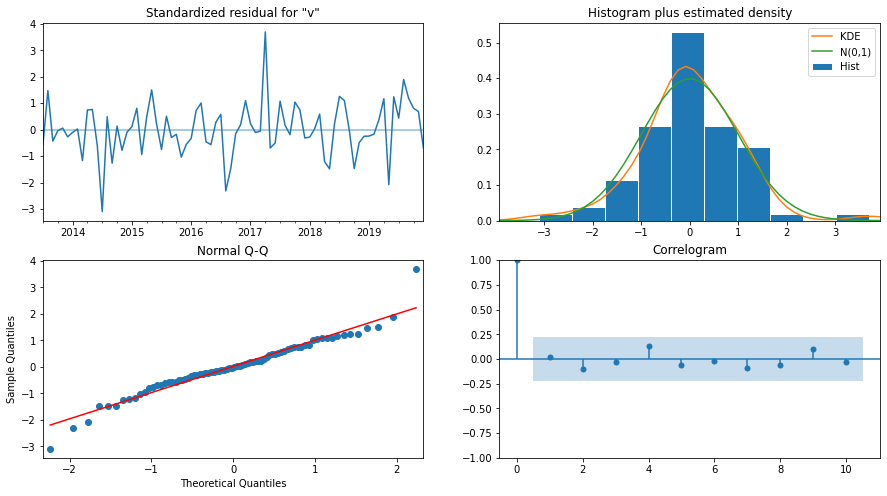

In [33]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()

Le graphique de autocorrélations des résidus est bien.

### Tests portmanteaux

In [34]:
residuals_sarima = pd.DataFrame(results.resid)
sm.stats.acorr_ljungbox(residuals_sarima)

,lb_stat,lb_pvalue
1,11.632130,0.000648
2,13.272273,0.001312
3,13.437087,0.003781
4,15.562216,0.003667
5,15.627161,0.007993
6,15.694183,0.015493
7,17.206667,0.016111
8,17.313403,0.027006
9,17.385253,0.043014
10,21.510581,0.017802


Les p-value sont toutes <5% : on rejette le modèle SARIMAX(0, 2, 3)x(0, 1, 1, 12)

### Prévision

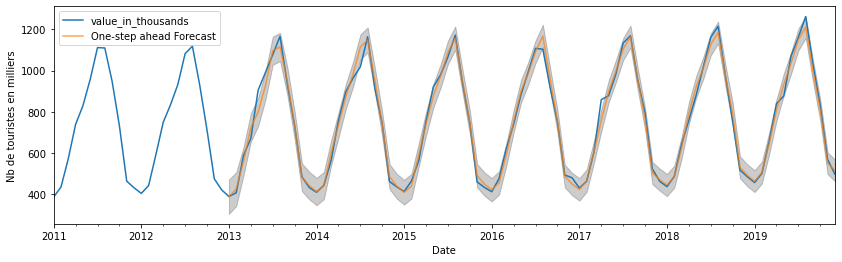

In [35]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_Official_Data_Sud3['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Nb de touristes en milliers')
plt.legend()
plt.show()

#### RMSE

In [36]:
df_forecasted = pred.predicted_mean
df_truth = df_Official_Data_Sud3['2013-01-01':]

rmse = mean_squared_error(df_truth, df_forecasted, squared=False)
rmse

31.17705236019104

#### Prédiction valeurs futures

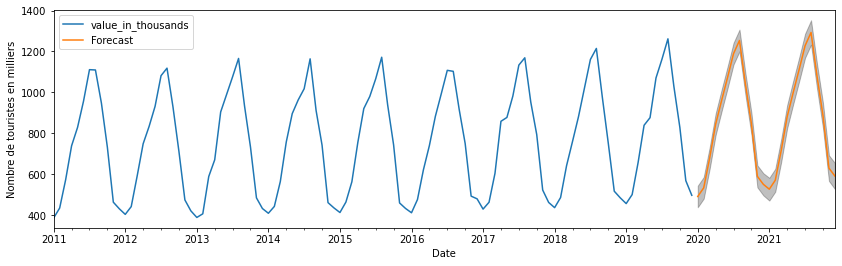

In [37]:
pred_uc = results.get_forecast(steps=24) #je prédis le nombre de touristes pour les 24 prochains mois
pred_ci = pred_uc.conf_int()
ax = df_Official_Data_Sud3.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Nombre de touristes en milliers')
plt.legend()
plt.show()

## Intégrer les nouvelles observations à chaque fois

In [38]:
df_Official_Data_Sud2

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64
2011-04-01,738.92
2011-05-01,828.78
...,...
2021-06-01,681.93
2021-07-01,1049.35
2021-08-01,1135.44


### Step 1: fitting the model on the available dataset

On suppose qu'on a toutes les données jusqu'à fin 2017, qu'on n'a pas encore les données suivantes, et qu'on les ajoute au fur et à mesure.

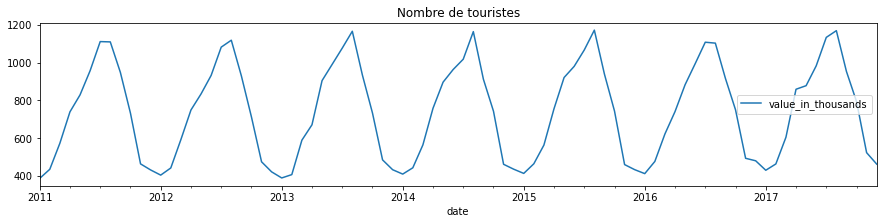

In [39]:
y_pre = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']<"2018-01-01"]
y_pre.set_index('date', inplace=True)
y_pre.plot(figsize=(15, 3), title='Nombre de touristes');

To construct forecasts, we first estimate the parameters of the model. This returns a results object that we will be able to use produce forecasts.  
On choisit le modèle qui minimise les critères d'information.

In [40]:
def choix_modele_sarima(pmax, dmax, qmax):

    p = range(0, 6)
    q = range(0, 4)
    d = range(0,3)
    pdq = list(itertools.product(p, d, q))

    p2 = d2 = q2 = range(0, 2)
    seasonal_pdq = list(itertools.product(p2,d2,q2))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]
    
    parametres_aic = {}
    parametres_bic = {}
    aics = []
    bics = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y_pre,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                parametres_aic.update({results.aic : [param, param_seasonal]})
                parametres_bic.update({results.bic : [param, param_seasonal]})
                aics.append(results.aic)
                bics.append(results.bic)


            except: 
                continue

    best_aic = min(aics)
    print(best_aic)
    print(parametres_aic[best_aic])

    best_bic = min(bics)
    print(best_bic)
    print(parametres_bic[best_bic])
    
    return([best_aic, parametres_aic[best_aic], best_bic, parametres_bic[best_bic]])

In [41]:
#choix_modele_sarima(6,3,4)

On fait un modèle SARIMAX(0, 2, 3)x(0, 1, 1, 12) qui minimise le BIC.

In [42]:
mod_pre = sm.tsa.statespace.SARIMAX(y_pre,
                                order=(0, 2, 3),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
res_pre = mod_pre.fit()
res_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   value_in_thousands   No. Observations:                   84
Model:             SARIMAX(0, 2, 3)x(0, 1, [1], 12)   Log Likelihood                -258.863
Date:                              Mon, 11 Apr 2022   AIC                            527.726
Time:                                      16:12:49   BIC                            537.671
Sample:                                  01-01-2011   HQIC                           531.561
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.1443     21.016     -0.102      0.919     -43.334      39.046
ma.L2          1.3003     24.230      0.054      0.957     -46.189      48.790
ma.L3         -0.1509      3.190     -0.047      0.962      -6.403       6.101
ma.S.L12      -1.0464      1.504     -0.696      0.487      -3.995       1.902
sigma2       572.3379   1.22e+04      0.047      0.962   -2.33e+04    2.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                29.71
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.25
Prob(H) (two-sided):                  0.36   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Les p-values ne sont pas significatives, à voir si on garde ça.

On fait la prédiction (sur les 4 prochains mois).

2018-01-01    445.148136
2018-02-01    484.964891
2018-03-01    625.082308
2018-04-01    792.774611
Freq: MS, Name: predicted_mean, dtype: float64


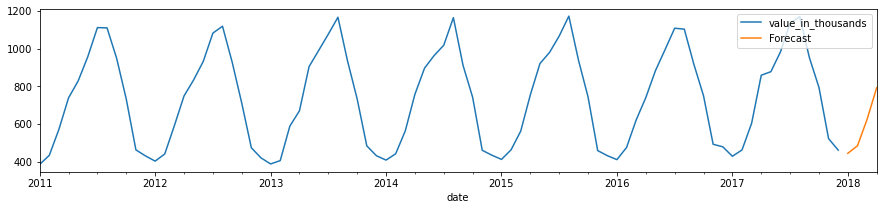

In [43]:
# Compute the forecasts
forecasts_pre = res_pre.forecast(4) #je prédis 4 mois
print(forecasts_pre)

# Plot the last 3 years of data and the four out-of-sample forecasts
y_pre.plot(figsize=(15, 3), label='Data', legend=True)
forecasts_pre.plot(label='Forecast', legend=True);

### Step 2: computing the “news” from a new observation  
Suppose that time has passed, and we have now received another observation. Our dataset is now larger, and we can evaluate our forecast error and produce updated forecasts for the subsequent quarters.

In [44]:
# Get the next observation after the "pre" dataset
y_update = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']=="2018-01-01"]
y_update.set_index('date', inplace=True)

# Print the forecast error
print('Forecast error: %.2f' % (y_update.iloc[0] - forecasts_pre.iloc[0]))

Forecast error: -8.42


To compute forecasts based on our updated dataset, we will create an updated results object res_post using the append method, to append on our new observation to the previous dataset.

In [45]:
# Create a new results object by passing the new observations to the `append` method
res_post = res_pre.append(y_update)

# Since we now know the value for 2018-01-01, we will only use `res_post` to produce forecasts
forecasts_post = pd.concat([y_update.rename(columns={'value_in_thousands':'predicted_mean'}), res_post.forecast('2018-04-01').to_frame()])
print(forecasts_post)

            predicted_mean
2018-01-01      436.730000
2018-02-01      485.965391
2018-03-01      624.832176
2018-04-01      792.481755


In [46]:
# Compute the impact of the news on the four periods that we previously forecasted: 2008Q3 through 2009Q2
news = res_pre.news(res_post, start='2018-01-01', end='2018-04-01')

The variable news is an object of the class NewsResults, and it contains details about the updates to the data in res_post compared to res_pre, the new information in the updated dataset, and the impact that the new information had on the forecasts in the period between start and end.

In [47]:
print(news.summary())

                                       News                                      
Model:                        SARIMAX   Original sample:      2011-01-01 00:00:00
Date:                Mon, 11 Apr 2022                       - 2017-12-01 00:00:00
Time:                        16:12:50   Update through:       2018-01-01 00:00:00
                                        No. Revisions:                          0
                                        No. New datapoints:                     1
       Impacts for [impacted variable = value_in_thousands]      
        impact date estimate (prev) impact of news estimate (new)
-----------------------------------------------------------------
2018-01-01 00:00:00          445.15          -8.42         436.73
2018-02-01 00:00:00          484.96           1.00         485.97
2018-03-01 00:00:00          625.08          -0.25         624.83
2018-04-01 00:00:00          792.77          -0.29         792.48
                       News from updated obser

Summary output: the default summary for this news results object printed four tables:  

1- Summary of the model and datasets 
  
2- Details of the news from updated data : This table simply shows the forecasts from the previous results for observations that were updated in the updated sample.  
  
3- Summary of the impacts of the new information on the forecasts between start='2018-01-01' and end='2018-04-01'
- The previous forecast for each of the impact dates, in the “estimate (prev)” column
- The impact that the new information (the “news”) had on the forecasts for each of the impact dates, in the “impact of news” column
- The updated forecast for each of the impact dates, in the “estimate (new)” column  

4- Details of how the updated data led to the impacts on the forecasts between start='2018-01-01' and end='2018-04-01' : The fourth table shows how each new observation translated into specific impacts at each impact date.  
The first three columns table described the relevant update (an “updated” is a new observation):
- The first column (“update date”) shows the date of the variable that was updated.
- The second column (“forecast (prev)”) shows the value that would have been forecasted for the update variable at the update date based on the previous results / dataset.
- The third column (“observed”) shows the actual observed value of that updated variable / update date in the updated results / dataset.  

The last four columns described the impact of a given update (an impact is a changed forecast within the “impact periods”).
- The fourth column (“impact date”) gives the date at which the given update made an impact.
- The fifth column (“news”) shows the “news” associated with the given update (this is the same for each impact of a given update, but is just not sparsified by default)
- The sixth column (“weight”) describes the weight that the “news” from the given update has on the impacted variable at the impact date. In general, weights will be different between each “updated variable” / “update date” / “impacted variable” / “impact date” combination.
- The seventh column (“impact”) shows the impact that the given update had on the given “impacted variable” / “impact date”.

## Prédiction en temps réel, qui intègre les nouvelles données --> boucle for

In [118]:
df_Official_Data_Sud2.head(3)

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64


In [119]:
df_Official_Data_Sud2_index.head(3)

,date,value_in_thousands
0,2011-01-01,386.57
1,2011-02-01,434.73
2,2011-03-01,572.64


In [111]:
#on imagine que l'on a toutes les données jusqu'à décembre 2017 de disponible
df_donnees_dispo = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']<"2018-01-01"]
df_donnees_dispo.set_index('date', inplace=True)

#on fit le modèle SARIMA(0, 2, 3)x(0, 1, 1, 12) sur ces données
modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                        order=(0, 2, 3),
                                        seasonal_order=(0, 1, 1, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

resultats_prev = modele_prev.fit()

In [112]:
#on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
df_forecast['date'] = df_Official_Data_Sud2_index['date'][(df_Official_Data_Sud2_index['date']<'2021-10-01') &
                                                           (df_Official_Data_Sud2_index['date']>="2018-01-01")]
df_forecast.set_index('date', drop=False, inplace=True)

In [113]:
resultats_prev_new = resultats_prev

for date in df_forecast['date']:
      
    #La valeur prédite :
    df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date)) 
    #je mets dans le dataframe la prédiction pour la date

    # La nouvelle observation qu'on a à disposition
    new_data = df_Official_Data_Sud2.loc[date, "value_in_thousands"]
    
    #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
    new_data2 = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']==date]
    new_data2.set_index('date', inplace=True)
        
    #On met la nouvelle observation dans le dataframe
    df_forecast.loc[date, 'donnee_officielle'] = new_data
    
    #Nouveau modèle fitté avec une donnée de plus :
    resultats_prev_new = resultats_prev_new.append(new_data2)

df_forecast    


,date,valeur_predite,donnee_officielle
date,,,
2018-01-01,2018-01-01,445.148136,436.73
2018-02-01,2018-02-01,485.965391,486.18
2018-03-01,2018-03-01,624.8065,641.41
2018-04-01,2018-04-01,790.400743,760.07
2018-05-01,2018-05-01,922.387322,880.83
2018-06-01,2018-06-01,1017.707817,1020.63
2018-07-01,2018-07-01,1125.684117,1160.83
2018-08-01,2018-08-01,1180.440424,1214.66
2018-09-01,2018-09-01,972.148519,976.43


<AxesSubplot:xlabel='date'>

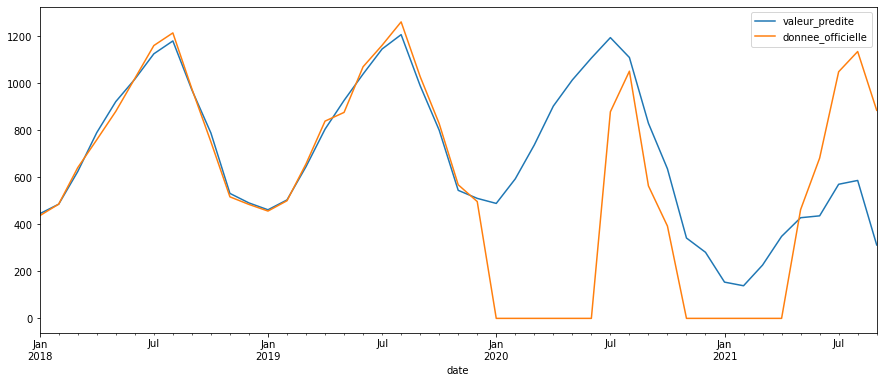

In [115]:
df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))